## **CIFAR10 image classification**

### **1. Load the dataset/Preprocess the data**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as python_random
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split

def set_random_seed(seed_value):
    np.random.seed(seed_value)
    python_random.seed(seed_value)
    tf.random.set_seed(seed_value)

def data_preprocessing(x, y):
  x = np.array(x, dtype=np.float32)
  y = np.array(y, dtype=np.float32)
  return x, y

def data_one_hot_encoding(x, y):
  x, y = data_preprocessing(x, y)
  y_ohe = to_categorical(y)
  return x, y_ohe

def get_train_valid_test_data(train_x, train_y, test_x, test_y, valid_size=0.2, random_state=42):
  train_x, train_y_ohe = data_one_hot_encoding(train_x, train_y)
  test_x, test_y_ohe = data_one_hot_encoding(test_x, test_y)
  train_x, valid_x, train_y_ohe, valid_y_ohe = train_test_split(train_x, train_y_ohe, test_size=valid_size, random_state=random_state)
  return (train_x, train_y_ohe), (valid_x, valid_y_ohe), (test_x, test_y_ohe)

set_random_seed(42)

(train_x, train_y), (test_x, test_y) = cifar10.load_data()
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(tr_x, tr_y_ohe), (val_x, val_y_ohe), (ts_x, ts_y_ohe) = \
get_train_valid_test_data(train_x, train_y, test_x, test_y, valid_size=0.15, random_state=42)
print(tr_x.shape, tr_y_ohe.shape, val_x.shape, val_y_ohe.shape, ts_x.shape, ts_y_ohe.shape)

170508288/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
(42500, 32, 32, 3) (42500, 10) (7500, 32, 32, 3) (7500, 10) (10000, 32, 32, 3) (10000, 10)


### **2. Data augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

b_size = 32

train_generator = ImageDataGenerator(horizontal_flip=True, rescale=1/255.0)
valid_generator = ImageDataGenerator(rescale=1/255.0)
test_generator = ImageDataGenerator(rescale=1/255.0)

train_generator_flow = train_generator.flow(tr_x, tr_y_ohe, batch_size=b_size, shuffle=True)
valid_generator_flow = valid_generator.flow(val_x, val_y_ohe, batch_size=b_size, shuffle=False)
test_generator_flow = test_generator.flow(ts_x, ts_y_ohe, batch_size=b_size, shuffle=False)

### **3. Build the model : Transfer learning(VGG16)**

In [ ]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

x_size = 32

input_tensor = Input(shape=(x_size, x_size, 3))
base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
base_model_output = base_model.output

x = GlobalAveragePooling2D()(base_model_output)
x = Dense(50, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

vgg_model = Model(inputs=input_tensor, outputs=output)
vgg_model.summary()

#base_model = VGG16(input_shape=(x_size, x_size, 3), include_top=False, weights='imagenet')
#base_model_output = base_model.output

#x = GlobalAveragePooling2D()(base_model_output)
#x = Dense(50, activation='relu')(x)
#output = Dense(10, activation='softmax')(x)

#vgg_model = Model(inputs=vgg_model.input, outputs=output)
#vgg_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

### **4. Compile/Train the model**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

vgg_model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

cb_rlr = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.2, verbose=0)
cb_esp = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)

In [ ]:
history = vgg_model.fit(train_generator_flow, validation_data=valid_generator_flow, epochs=50, callbacks=[cb_rlr, cb_esp])

Epoch 1/50
1329/1329 [==============================] - 39s 22ms/step - loss: 1.8566 - accuracy: 0.2614 - val_loss: 1.6196 - val_accuracy: 0.3217 - lr: 0.0010
Epoch 2/50
1329/1329 [==============================] - 28s 21ms/step - loss: 1.4501 - accuracy: 0.4224 - val_loss: 1.3281 - val_accuracy: 0.5116 - lr: 0.0010
Epoch 3/50
1329/1329 [==============================] - 28s 21ms/step - loss: 1.1749 - accuracy: 0.5725 - val_loss: 1.0496 - val_accuracy: 0.6284 - lr: 0.0010
Epoch 4/50
1329/1329 [==============================] - 28s 21ms/step - loss: 0.9933 - accuracy: 0.6510 - val_loss: 1.0730 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 5/50
1329/1329 [==============================] - 28s 21ms/step - loss: 0.8702 - accuracy: 0.6963 - val_loss: 0.8715 - val_accuracy: 0.6948 - lr: 0.0010
Epoch 6/50
1329/1329 [==============================] - 28s 21ms/step - loss: 0.7914 - accuracy: 0.7260 - val_loss: 0.8444 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 7/50
1329/1329 [========================

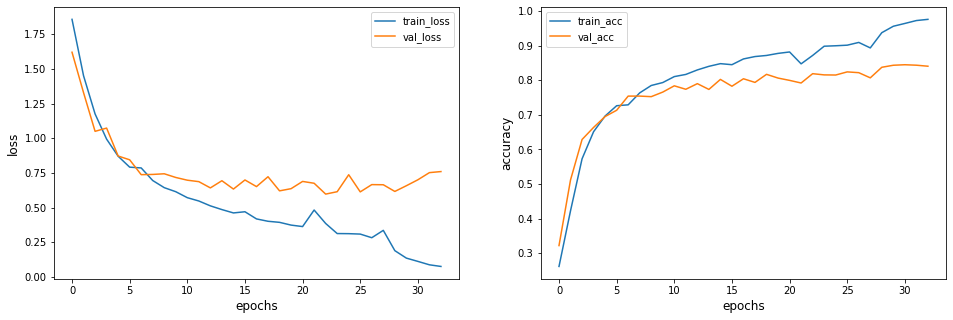

In [ ]:
def show_history(history):
  fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
  axs[0].plot(history.history['loss'], label='train_loss')
  axs[0].plot(history.history['val_loss'], label='val_loss')

  axs[1].plot(history.history['accuracy'], label='train_acc')
  axs[1].plot(history.history['val_accuracy'], label='val_acc')

  axs[0].legend()
  axs[0].set_xlabel('epochs', fontsize=12)
  axs[0].set_ylabel('loss', fontsize=12)

  axs[1].legend()
  axs[1].set_xlabel('epochs', fontsize=12)
  axs[1].set_ylabel('accuracy', fontsize=12)
  plt.show()

show_history(history)

### **5. Evaluate the model**

In [ ]:
vgg_model.evaluate(test_generator_flow)

313/313 [==============================] - 3s 10ms/step - loss: 0.8210 - accuracy: 0.8363


[0.821035623550415, 0.8363000154495239]